In [1]:
#%matplotlib inline
import ROOT
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, cout
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
#plotting, style
from matplotlib import pyplot as plt
ROOT.gStyle.SetOptStat('')
from AtlasCommonUtils import *
from Legend import Legend
from ROOT import TLatex
SetAtlasStyle()
ROOT.gStyle.SetPalette(ROOT.kViridis);


Welcome to JupyROOT 6.09/01


/root/myROOT/lib/ROOT.py:432: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [2]:
def divideBinWidth(histo):
    for i in range(histo.GetNbinsX()):
        histo.SetBinContent(i,histo.GetBinContent(i)/histo.GetBinWidth(i))
        histo.SetBinError(i, histo.GetBinError(i)/histo.GetBinWidth(i))
    return histo

TFile: name=OutputData/fout_16_17g6a3_pthat2_latest_small.root, title=, option=READ


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Matrix.png has been created


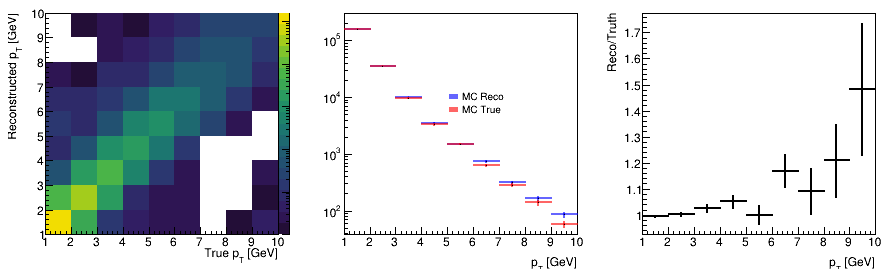

In [85]:
#MCfile = ROOT.TFile('OutputData/fout_16_17g6a3_pthat2_clusterv2_small.root')
MCfile = ROOT.TFile('OutputData/fout_16_17g6a3_pthat2_latest_small.root')
MCfile.Print()
responseMatrix = MCfile.Get("hCorrelation");
#responseMatrix.Rebin2D(2,2)
responseMatrix.ClearUnderflowAndOverflow()
mc_truth = responseMatrix.ProjectionX()
mc_reco = responseMatrix.ProjectionY()
mc_truth.Sumw2()
mc_reco.Sumw2()
mc_truth.SetLineColorAlpha(2,0.6)
mc_reco.SetLineColorAlpha(4,0.6)


##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',900,300)
c.Divide(3)
c.cd(1)
responseMatrix.Draw('colz')
ROOT.gPad.SetLogz()
c.cd(2)

label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

mc_reco.SetXTitle('p_{T} [GeV]')
mc_reco.Draw()
mc_truth.Draw("same")
label.Draw(0.5,.7)
ROOT.gPad.SetLogy()
c.cd(3)
ratio_mc = mc_reco.Clone()
ratio_mc.SetLineColor(1)
ratio_mc.Divide(mc_truth)
ratio_mc.Draw('L')
ratio_mc.SetYTitle('Reco/Truth')
c.Draw()
c.SaveAs('Matrix.png')

TFile: name=OutputData/fout_16_13b_pass4_v2_1run.root, title=, option=READ


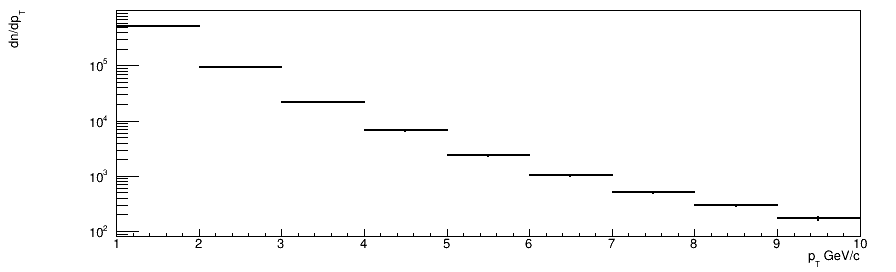

In [72]:
Datafile = ROOT.TFile('OutputData/fout_16_13b_pass4_v2_1run.root')
Datafile.Print()
data = Datafile.Get('track_pt')
data.ClearUnderflowAndOverflow()
#data.Rebin(2)
#for i in range(10):
#    data.SetBinContent(i,0)
#    data.SetBinError(i,0)
#data.SetBinContent(data.GetNbinsX(),0)
c.Clear()
data.Draw()
ROOT.gPad.SetLogy()
c.Draw()

In [83]:
response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix)
response.UseOverflow(ROOT.kFALSE)
unfold_bayes = RooUnfoldBayes     (response, data,5);
unfold_SVD   = RooUnfoldSvd     (response, data, 3);
data_unfolded_bayes = unfold_bayes.Hreco();
data_unfolded_SVD   = unfold_SVD.Hreco();

Now unfolding...
Iteration : 0
Chi^2 of change 4248.44
Iteration : 1
Chi^2 of change 92.6349
Iteration : 2
Chi^2 of change 6.15664
Iteration : 3
Chi^2 of change 1.75818
Iteration : 4
Chi^2 of change 0.854274
Calculating covariances due to number of measured events
SVD init 9 x 9 bins, kreg=3


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.224196


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


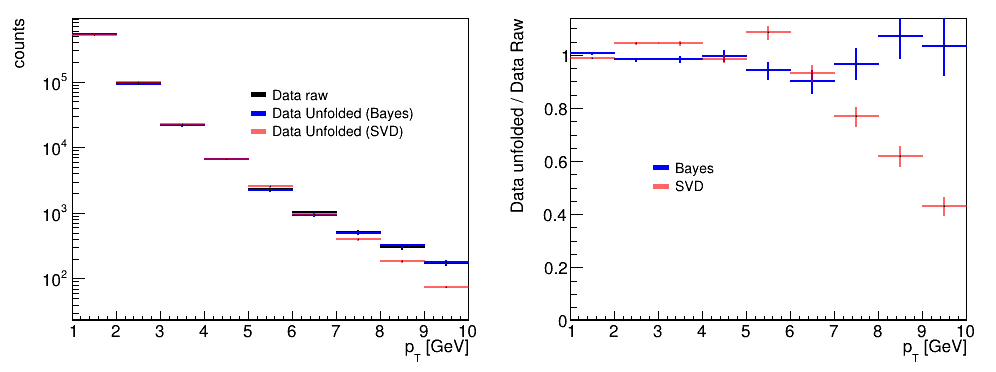

In [84]:
data_unfolded_bayes.SetLineColor(2)
data_unfolded_bayes.SetLineColor(4)


c = ROOT.TCanvas('c','c',1000,400)
c.Divide(2)
c.cd(1)
hstack = ROOT.THStack()
hstack.Add(data)
#data_unfolded.Scale(data.Integral()/data_unfolded.Integral())
hstack.Add(data_unfolded_bayes)
hstack.Add(data_unfolded_SVD)
hstack.SetTitle('; p_{T} [GeV]; counts')
hstack.Draw('nostack')
ROOT.gPad.SetLogy()

label = Legend("")
label.Add(data,'Data raw','L')
label.Add(data_unfolded_bayes,'Data Unfolded (Bayes)','L')
label.Add(data_unfolded_SVD, 'Data Unfolded (SVD)','L')
label.Draw(.5,.8)
c.cd(2)
ratio_bayes = data_unfolded_bayes.Clone()
ratio_bayes.Divide(data)

ratio_SVD   = data_unfolded_SVD.Clone()
ratio_SVD.Divide(data)

hs_ratio = ROOT.THStack()
hs_ratio.Add(ratio_bayes)
hs_ratio.Add(ratio_SVD)



hs_ratio.SetTitle('; p_{T} [GeV]; Data unfolded / Data Raw')
hs_ratio.Draw('nostack')

label = Legend("")
label.Add(ratio_bayes,'Bayes','L')
label.Add(ratio_SVD, 'SVD','L')
label.Draw(.3,.6)
c.Draw()

#Correcting for efficiency
